# Define baseline model

Com base nas nossas regras de negócio vamos definir o modelo baseline, também será feito um modelo simples e analisar como ele prever a tendência ao churn.

In [1]:
import os
os.chdir("../")

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import yaml

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from typing import Union
from src.features import convert_to_categoric
from src.features import classify_col

## 1 - Leitura dos dados

In [3]:
CAT_FEATS = [
    "tipo_de_empresa",
    "possui_mais_de_um_sócio",
    "funcionários",
    "utiliza_serviços_financeiros",
    "possuicontador",
    "faz_conciliação_bancária",
    "frequência_de_utilização_de_feature_do_sistema_módulo_financeiro",
    "frequência_de_utilização_de_feature_do_sistema_emissão_de_nota_fiscal",
    "frequência_de_utilização_de_feature_do_sistema_integração_bancária",
    "frequência_de_utilização_de_feature_do_sistema_módulo_de_vendas",
    "frequência_de_utilização_de_feature_do_sistema_relatórios",
    "frequência_de_utilização_de_feature_do_sistema_utilização_de_apis_de_integração",
    "contrato",
    "emite_boletos",
    "tipo_de_pagamento",
    "churn"
]

cat_dtypes = {c:"category" for c in CAT_FEATS}

df = pd.read_csv("./data/processed/cleared_df.csv",dtype=cat_dtypes)
df.head()

,tipo_de_empresa,fundação_da_empresa,possui_mais_de_um_sócio,funcionários,meses_de_permanência,utiliza_serviços_financeiros,possuicontador,faz_conciliação_bancária,frequência_de_utilização_de_feature_do_sistema_módulo_financeiro,frequência_de_utilização_de_feature_do_sistema_emissão_de_nota_fiscal,frequência_de_utilização_de_feature_do_sistema_integração_bancária,frequência_de_utilização_de_feature_do_sistema_módulo_de_vendas,frequência_de_utilização_de_feature_do_sistema_relatórios,frequência_de_utilização_de_feature_do_sistema_utilização_de_apis_de_integração,contrato,emite_boletos,tipo_de_pagamento,receita_mensal,receita_total,churn
0,Micro empresa,2016,Sim,até 5 funcionários,1,Não,NaN,automática,Pouco uso,Uso frequente,Pouco uso,Pouco uso,Pouco uso,Pouco uso,Mês-a-mês,1,Boleto - pagamento único,29.85,29.85,Não
1,Pequena empresa,2018,Não,até 5 funcionários,34,Sim,Não,automática,Uso frequente,Pouco uso,Uso frequente,Pouco uso,Pouco uso,Pouco uso,Trimestral,0,Boleto - mês a mês,56.95,1889.50,Não
2,Pequena empresa,2021,Não,até 5 funcionários,2,Sim,Não,automática,Uso frequente,Uso frequente,Pouco uso,Pouco uso,Pouco uso,Pouco uso,Mês-a-mês,1,Boleto - mês a mês,53.85,108.15,Sim
3,Pequena empresa,2016,Não,até 5 funcionários,45,Não,NaN,automática,Uso frequente,Pouco uso,Uso frequente,Uso frequente,Pouco uso,Pouco uso,Trimestral,0,Cartão de crédito - pagamento único,42.30,1840.75,Não
4,Micro empresa,2017,Não,até 5 funcionários,2,Sim,Não,manual,Pouco uso,Pouco uso,Pouco uso,Pouco uso,Pouco uso,Pouco uso,Mês-a-mês,1,Boleto - pagamento único,70.70,151.65,Sim


In [4]:
df.dtypes

tipo_de_empresa                                                                    category
fundação_da_empresa                                                                   int64
possui_mais_de_um_sócio                                                            category
funcionários                                                                       category
meses_de_permanência                                                                  int64
utiliza_serviços_financeiros                                                       category
possuicontador                                                                     category
faz_conciliação_bancária                                                           category
frequência_de_utilização_de_feature_do_sistema_módulo_financeiro                   category
frequência_de_utilização_de_feature_do_sistema_emissão_de_nota_fiscal              category
frequência_de_utilização_de_feature_do_sistema_integração_bancária              

## 2 - Agregando algumas features

Agrupando dados da feature `Meses de permanência`

In [5]:
map_temp_perm = {
    "Menor que 3 meses":range(0,3),
    "Entre 3 a 12 meses":range(3,12),
    "Entre 12 a 36 meses":range(12,36),
    "Maior que 36 meses":range(36,100),
}

df = classify_col(dataframe=df,col_to_clf="meses_de_permanência",new_col_name="clf_meses_permanência",map=map_temp_perm)
df = convert_to_categoric(dataframe=df,subset="clf_meses_permanência")
df["clf_meses_permanência"].value_counts()

clf_meses_permanência
Maior que 36 meses     3051
Entre 12 a 36 meses    1923
Entre 3 a 12 meses     1207
Menor que 3 meses       862
Name: count, dtype: int64

In [6]:
cols_freq = [
"frequência_de_utilização_de_feature_do_sistema_módulo_financeiro",
"frequência_de_utilização_de_feature_do_sistema_emissão_de_nota_fiscal",
"frequência_de_utilização_de_feature_do_sistema_integração_bancária",
"frequência_de_utilização_de_feature_do_sistema_módulo_de_vendas",
"frequência_de_utilização_de_feature_do_sistema_relatórios",
"frequência_de_utilização_de_feature_do_sistema_utilização_de_apis_de_integração"
]
df["qty_PoucoUso_features"] = df[cols_freq].map(
    func=lambda d: 1 if d=="Pouco uso" else 0,
).agg("sum",axis=1)

df["qty_PoucoUso_features"].value_counts()

qty_PoucoUso_features
0    1810
3    1118
4    1033
5     966
2     852
6     693
1     571
Name: count, dtype: int64

## 4 - Separando os dados de treinamento e validação

In [7]:
TARGET = "churn"
CAT_FEATURES = list(df.select_dtypes(include=["category"],exclude=["int64","float64"]).columns)
CAT_FEATURES.remove(TARGET)
NUM_FEATURES = list(df.select_dtypes(include=["int64","float64"],exclude=["category"]).columns)
FEATURES = CAT_FEATURES+NUM_FEATURES

In [8]:
X = df[FEATURES]
y = df[TARGET].map({"Não":0,"Sim":1})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train, y_train shape:",(X_train.shape,y_train.shape))
print("X_test, y_test:",(X_test.shape,y_test.shape))

X_train, y_train shape: ((5634, 21), (5634,))
X_test, y_test: ((1409, 21), (1409,))


In [9]:
## save train and test data 
train_data = pd.concat([X_train,y_train],axis=1)
test_data = pd.concat([X_test,y_test],axis=1)

train_data.to_csv("./data/processed/train_data.csv",index=False)
test_data.to_csv("./data/processed/test_data.csv",index=False)

## 5 - Aplicando regra de negócio

Vamos considerar que o Churn será feito para empresas com menos de 12 meses de tempo de permanância e a quantidade de features com pouco uso é maior ou igual do que 3.

In [10]:
print("Proporção de churn nos dados de treino")
y_train.value_counts(normalize=True)

Proporção de churn nos dados de treino


churn
0    0.734469
1    0.265531
Name: proportion, dtype: float64

In [11]:
heuristic_predict = ((X_test["qty_PoucoUso_features"]>=3)&(
    (X_test["clf_meses_permanência"]=="Menos que 3 meses")|
    (X_test["clf_meses_permanência"]=="Entre 3 a 12 meses")
)).map({False:0,True:1})

heuristic_predict.value_counts(normalize=True)

0    0.882896
1    0.117104
Name: proportion, dtype: float64

In [12]:
print(classification_report(y_test, heuristic_predict, target_names=['non-churn', 'churn']))

              precision    recall  f1-score   support

   non-churn       0.76      0.92      0.83      1036
       churn       0.48      0.21      0.30       373

    accuracy                           0.73      1409
   macro avg       0.62      0.57      0.57      1409
weighted avg       0.69      0.73      0.69      1409



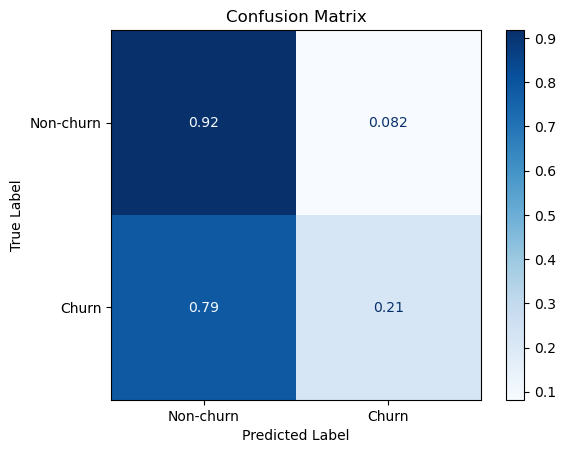

In [19]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, heuristic_predict, normalize='true')

# Define the class labels
labels = ['Non-churn', "Churn"]  # Replace with your class labels

# Create a confusion matrix display
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Plot the confusion matrix
cm_display.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

O modelo apenas com regra de negócio apresentou um forte bias a não classificar churn. Por consequência do nosso dataset também ser desbalanceado, apenas utilizar uma única regra de negócio não parece ser suficiente para definir churn, por isso, uma abordagem com ML parece ser uma melhor solução.

## 6 - Decision Tree com as features atuais

Vamos criar uma decision tree para gerar as previsões de churn. A decision tree é conhecida por ser um modelo não linear que constrói uma árvore de decisão na qual as regras de classificação são definidas através do ganho de informação de uma feature. Ela é conhecida por um modelo simples e intuitivo, podemos visualizar as regras de classificação, o que as torna modelos bem explicáveis. Vamos avaliar quão bem ela consegue prever o churn no nosso dataset.

In [13]:
# Define the pipeline
# Create the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), NUM_FEATURES),
        ('cat', OneHotEncoder(), CAT_FEATURES)])

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocessing (imputation + one-hot encoding)
    ('model', DecisionTreeClassifier(class_weight='balanced',random_state=42))  # Model
])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['fundação_da_empresa',
                                                   'meses_de_permanência',
                                                   'receita_mensal',
                                                   'receita_total',
                                                   'qty_PoucoUso_features']),
                                                 ('cat', OneHotEncoder(),
                                                  ['tipo_de_empresa',
                                                   'possui_mais_de_um_sócio',
                                                   'funcionários',
                                                   'utiliza_serviços_financeiros',
                                                   'possuicontador',
                                                   'faz_conci...
                                                   'frequência_de_utilização_de_feature_do_sistema_módulo_de_vendas',
                                                   'frequência_de_utilização_de_feature_do_sistema_relatórios',
                                                   'frequência_de_utilização_de_feature_do_sistema_utilização_de_apis_de_integração',
                                                   'contrato', 'emite_boletos',
                                                   'tipo_de_pagamento',
                                                   'clf_meses_permanência'])])),
                ('model',
                 DecisionTreeClassifier(class_weight='balanced',
                                        random_state=42))])

In [14]:
y_pred_class = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_class,target_names=['non-churn', 'churn']))

              precision    recall  f1-score   support

   non-churn       0.82      0.82      0.82      1036
       churn       0.50      0.49      0.50       373

    accuracy                           0.74      1409
   macro avg       0.66      0.66      0.66      1409
weighted avg       0.74      0.74      0.74      1409



In [15]:
print("proporção de não churn e churn:")
cat,ncat = np.unique(y_pred_class,return_counts=True)
for cat, qty in zip(cat,ncat):
    print(f"{cat}:{qty/np.sum(ncat,axis=0)}")

proporção de não churn e churn:
0:0.7402413058907026
1:0.25975869410929736


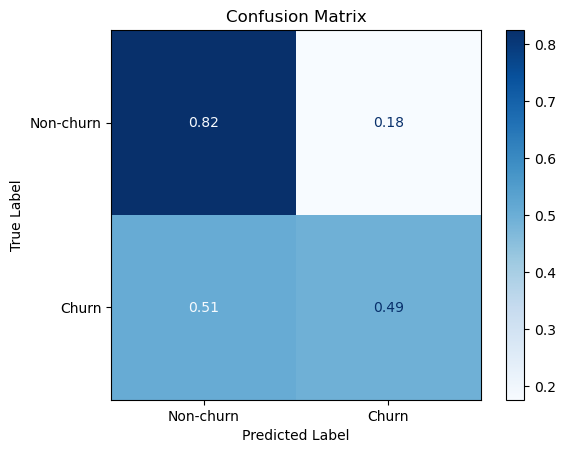

In [16]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_class, normalize='true')

# Define the class labels
labels = ['Non-churn', "Churn"]  # Replace with your class labels

# Create a confusion matrix display
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Plot the confusion matrix
cm_display.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

A decision tree conseguiu melhorar a performance em comparação ao modelo feito somente com regras de negócio, contudo, ainda apresenta uma dificuldade de classificação de churn. Realizar ajuste na decision tree é possível mas isso pode a levar a ser um modelo complexo com tendência ao overfiting, por isso, vamos testar outros algortimos de classificação.

## 7 - Save configs

In [18]:
OUTPUT_PATH = Path("./config")

model_name = "decision_tree_clf_for_churn"

num_features = [str.encode(col,encoding="ISO-8859-1") for col in NUM_FEATURES]
cat_features = [str.encode(col,encoding="ISO-8859-1") for col in CAT_FEATURES]

fit_model_params = pipeline.named_steps["model"].get_params()

MODEL_PARAMETERS = {
    "model_name":model_name,
    "model_version":1,
    "model_parameters":{
        "fit_params":fit_model_params
        },
    "model_features":{"NUM_FEATURES":num_features,"CAT_FEATURES":cat_features},
    "model_target":"churn"
}


if OUTPUT_PATH.is_dir():
    with open(f"{OUTPUT_PATH}/{model_name}_config.yaml","w") as f:
        yaml.dump(MODEL_PARAMETERS,f)
else:
    OUTPUT_PATH.mkdir(exist_ok=True,parents=True)
    with open(f"{OUTPUT_PATH}/f{model_name}_config.yaml","w") as f:
        yaml.dump(MODEL_PARAMETERS,f)

## 8 - Conclusão

- Construímos duas baselines: 1 - a partir do modelo de negócio e 2 - com uma decision tree simples e features base (`Tipo de empresa`,`Fundação da empresa`, `Possui mais de um sócio`, `Funcionários`, `Utiliza serviços financeiros`, `PossuiContador`,`Faz conciliação bancária`, `Contrato`, `Emite boletos.1`,`Tipo de pagamento`, `Receita mensal`, `Receita total`, `Churn`,`clf_meses_permanência`, `quantidade_PoucoUso_features`)
- A principal métrica para se acompanhar aqui é a f1-score: em problemas de Churn queremos um balanço entre precision e recall. Precision pois ela diminui a quantidade de falsos positivos (nesse caso, se previu o Churn mas a empresa não fez Churn) logo diminui o custo de manter um cliente, já o recall é importante pois ele diminui a quantidade de falsos negativos (não se prevê o Churn mas ocorre Churn) o que diminui a quantidade de perdas por desligamentos. Sendo assim, ambos são importantes de evitar e então se escolhe a f1-score para melhorar.
- o modelo baseline 1 baseado em regra de negócio vimos que temos um forte bias para não classificar o Churn, logo, para previsão de Churn obtemos: precision: 0.48, recall: 0.21 e f1-score:0.3
- O modelo baseline 2 baseado em ML e features base já apresentou uma melhora no recall e f1-score para previsão de Churn, os resultados obtidos (precision: 0.50, recall: 0.49 e f1-score:0.50) contudo ainda assim identificando muito falsos negativos, logo, um modelo mais robusto e um melhor tratamento de features é importante para melhorar os resultados.